# Perform Manders's colocalization of MSSR ROI images
It runs over the data created with the oib2ome-zarr.ipynb

## Install Libraries

In [42]:
!pip install ome-zarr
!pip install PyQt5
!pip install napari[all]
!pip install git+https://github.com/RoccoDAnt/napari-superres.git

  Cloning https://github.com/RoccoDAnt/napari-superres.git to /tmp/pip-req-build-q9nd37fu
  Running command git clone --filter=blob:none --quiet https://github.com/RoccoDAnt/napari-superres.git /tmp/pip-req-build-q9nd37fu
  Resolved https://github.com/RoccoDAnt/napari-superres.git to commit 44bbbf03eb6207bc2e618cc1763cd76331033913
  Preparing metadata (setup.py) ... done


## Import libraries

In [43]:
import zarr
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian
from napari_superres.core_mssr import mssr_class
mssr_instance = mssr_class()

## Define File Paths

In [3]:
directory_path = '/home/jovyan/LNMA/bravoa/data/New2 Fig para colocalizacion Manders-Mito'
ome_zarr_name = '1-Cry11 2mg 2h MitoT 750nM 60xmed-post 3.5 Z copy.zarr'
ome_zarr_path = os.path.join(directory_path, ome_zarr_name)
ome_zarr_path

'/home/jovyan/LNMA/bravoa/data/New2 Fig para colocalizacion Manders-Mito/1-Cry11 2mg 2h MitoT 750nM 60xmed-post 3.5 Z copy.zarr'

## Define Parameters

In [36]:
# folder_path = wd + 'New Fig para colocalizacion Manders-Mito'
# order_types = ['Cit']
ch_m1 = 1
ch_m2 = 2
# nameForPDFs = 'Toxin_vs_Mito'


### Parameters for MSSR

fwhm = 8  # Full Width at Half Maximum
amp = 1  # Amplitude
order = 1  # Order
mesh = True  # Optional, default is True
ftI = False  # Optional, default is False
intNorm = True  # Optional, default is True
sigma = 2 # For the Gassian filter

## Define Functions

In [45]:
# Extract the rectangular region from the specified channel
def extract_rect_roi(image, left, top, width, height):
    return image[top:top+height, left:left+width]

def manders_colocalization(image1, image2):
    overlap = np.logical_and(image1 > 0, image2 > 0)
    m1 = np.sum(overlap) / np.sum(image1 > 0) if np.sum(image1 > 0) > 0 else 0
    m2 = np.sum(overlap) / np.sum(image2 > 0) if np.sum(image2 > 0) > 0 else 0
    return m1, m2

## Load the OME-Zarr file

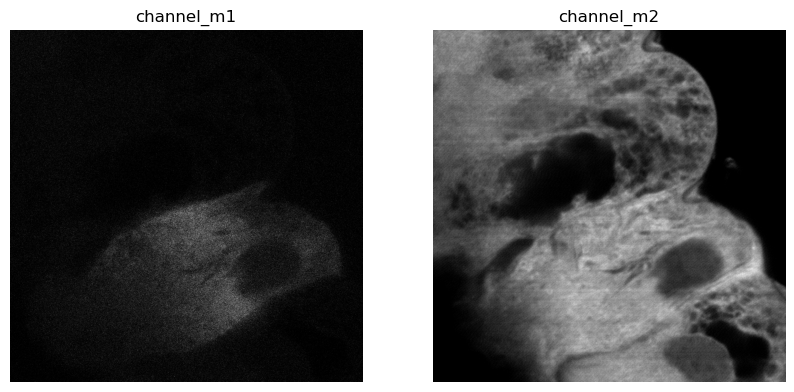

In [20]:
images = zarr.open(ome_zarr_path, mode="r")
channel_m1 = images["image_data"][0, ch_m1, 0, :, :].astype(np.float32)
channel_m2 = images["image_data"][0, ch_m2, 0, :, :].astype(np.float32)

# Set up the figure with two subplots
plt.figure(figsize=(10, 5))

# Display the first image
plt.subplot(1, 2, 1)
plt.title("channel_m1")
plt.imshow(channel_m1, cmap="gray")
plt.axis('off')

# Display the second image
plt.subplot(1, 2, 2)
plt.title("channel_m2")
plt.imshow(channel_m2, cmap="gray")
plt.axis('off')

# Show the figure
plt.show()

## Extract ROI metadata from the OME-Zarr file

In [5]:
roi_metadata = images.attrs.get("roi_metadata", {})
# Assuming roi_metadata is a list of dictionaries with each ROI's information
roi_names = [roi.get('name') for roi in roi_metadata]

# Print all ROI names
for i, roi_name in enumerate(roi_names):
    print(f"ROI {i} Name:", roi_name)

ROI 0 Name: 0003-0616-0452-CitVerde-Mito
ROI 1 Name: 0003-0572-0546-CitVerde-Mito
ROI 2 Name: 0003-0660-0562-CitVerde-Mito
ROI 3 Name: 0003-0806-0550-CitVerde-Mito
ROI 4 Name: 0003-0802-0620-CitVerde-Mito
ROI 5 Name: 0003-0866-0592-CitVerde-Mito
ROI 6 Name: 0002-0688-0708-NucleoVerde-Mito
ROI 7 Name: 0002-0744-0706-NucleoVerde-Mito
ROI 8 Name: 0002-0726-0466-CitVerde-Mito
ROI 9 Name: 0001-0804-0472-CitVerde-Mito


## Process each .roi file

In [61]:
M = []

for roi_info in roi_metadata:

    left = roi_info['left']
    top = roi_info['top']
    width = roi_info['width']
    height = roi_info['height']

    # Extract ROIs
    roi_channel_m1 = extract_rect_roi(channel_m1, left, top, width, height)
    roi_channel_m2 = extract_rect_roi(channel_m2, left, top, width, height)
    
    # Apply Gaussian filter
    roi_channel_m1 = gaussian(roi_channel_m1, sigma)
    roi_channel_m2 = gaussian(roi_channel_m1, sigma)

    # Apply MSSR
    roi_channel_m1_mssr = mssr_instance.sfMSSR(img=roi_channel_m1,
                                               fwhm=fwhm, amp=amp,
                                               order=order,
                                               mesh=mesh, ftI=ftI,
                                               intNorm=intNorm)
    
    roi_channel_m2_mssr = mssr_instance.sfMSSR(img=roi_channel_m2,
                                               fwhm=fwhm, amp=amp,
                                               order=order,
                                               mesh=mesh, ftI=ftI,
                                               intNorm=intNorm)
    
    # Compute Manders' colocalization coefficients after MSSR
    m1, m2 = manders_colocalization(roi_channel_m1_mssr, roi_channel_m2_mssr)

    # Append the results as a tuple
    M.append((roi_info['name'], round(m1, 3), round(m2, 3)))
    
    print(f"ROI Name:", roi_info['name'])
    print(f"Manders' colocalization coefficients M1 = {round(m1, 3)}, M2 = {round(m2, 3)}")


progress: 100%|██████████| 9/9 [00:00<00:00, 1924.48it/s]


ROI Name: 0003-0616-0452-CitVerde-Mito
Manders' colocalization coefficients M1 = 0.866, M2 = 0.874


progress: 100%|██████████| 9/9 [00:00<00:00, 2990.00it/s]


ROI Name: 0003-0572-0546-CitVerde-Mito
Manders' colocalization coefficients M1 = 0.855, M2 = 0.858


progress: 100%|██████████| 9/9 [00:00<00:00, 227.13it/s]


ROI Name: 0003-0660-0562-CitVerde-Mito
Manders' colocalization coefficients M1 = 0.859, M2 = 0.839


progress: 100%|██████████| 9/9 [00:00<00:00, 2884.89it/s]


ROI Name: 0003-0806-0550-CitVerde-Mito
Manders' colocalization coefficients M1 = 0.868, M2 = 0.842


progress: 100%|██████████| 9/9 [00:00<00:00, 2478.09it/s]


ROI Name: 0003-0802-0620-CitVerde-Mito
Manders' colocalization coefficients M1 = 0.864, M2 = 0.869


progress: 100%|██████████| 9/9 [00:00<00:00, 2555.60it/s]


ROI Name: 0003-0866-0592-CitVerde-Mito
Manders' colocalization coefficients M1 = 0.842, M2 = 0.848


progress: 100%|██████████| 9/9 [00:00<00:00, 2726.92it/s]


ROI Name: 0002-0688-0708-NucleoVerde-Mito
Manders' colocalization coefficients M1 = 0.823, M2 = 0.84


progress: 100%|██████████| 9/9 [00:00<00:00, 2710.08it/s]


ROI Name: 0002-0744-0706-NucleoVerde-Mito
Manders' colocalization coefficients M1 = 0.842, M2 = 0.859


progress: 100%|██████████| 9/9 [00:00<00:00, 2680.64it/s]


ROI Name: 0002-0726-0466-CitVerde-Mito
Manders' colocalization coefficients M1 = 0.85, M2 = 0.85


progress: 100%|██████████| 9/9 [00:00<00:00, 2453.13it/s]

ROI Name: 0001-0804-0472-CitVerde-Mito
Manders' colocalization coefficients M1 = 0.856, M2 = 0.851
